<a href="https://colab.research.google.com/github/Fugant1/statistical-analysis-ENEM-grades/blob/main/An%C3%A1lise_Estat%C3%ADstica_Notas_Enem_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de Inferência Estatística: Fatores Socioeconômicos e Desempenho no ENEM 2018

### 1. Introdução e Contextualização

O Exame Nacional do Ensino Médio (ENEM) é um dos vestibulares mais importantes do Brasil, sendo a principal porta de entrada para o ensino superior. O desempenho dos estudantes nesta avaliação é influenciado por uma complexa rede de fatores que vão além da dedicação e do conhecimento técnico. Variáveis socioeconômicas e demográficas desempenham um papel crucial na determinação das oportunidades e, consequentemente, dos resultados.

**Este projeto se propõe a analisar os microdados do ENEM de 2018** para investigar a relação entre o desempenho dos candidatos e três fatores principais: **renda familiar, raça/cor autodeclarada e sexo**.

### 2. Objetivo do Estudo

O objetivo central deste trabalho é aplicar técnicas de inferência estatística para verificar se as diferenças de notas observadas entre os grupos mencionados são estatisticamente significativas. Para isso, serão realizados testes de hipótese não paramétricos, adequados à distribuição dos dados, a fim de responder às seguintes perguntas:

* A renda familiar tem impacto significativo na nota da redação?
* Existe uma diferença significativa na nota média geral entre candidatos de diferentes raças/cores?
* O desempenho médio geral no exame difere de forma significativa entre os sexos?

#Imports das bibliotecas e do banco de dados

In [ ]:
# Importa as bibliotecas necessárias para a configuração
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
import seaborn as sns
import zipfile

In [ ]:
# Instala a biblioteca do Kaggle de forma silenciosa
!pip install kaggle -q

# Credenciais privadas do grupo; por favor cuidado aqui!
kaggle_credentials = {
    "username": "",
    "key": ""
}

# Cria o diretório .kaggle no local correto
kaggle_dir = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_dir, exist_ok=True)

# Grava as credenciais no arquivo kaggle.json
with open(os.path.join(kaggle_dir, "kaggle.json"), "w") as f:
    json.dump(kaggle_credentials, f)

# Define as permissões de segurança para o arquivo
!chmod 600 ~/.kaggle/kaggle.json

print("✅ Credenciais do Kaggle configuradas com sucesso!")

✅ Credenciais do Kaggle configuradas com sucesso!


In [ ]:
!kaggle datasets download -d emanueliwanow/enem-2018

# Define os nomes do arquivo e da pasta para descompactar
zip_filename = 'enem-2018.zip'
extract_folder = 'dados_enem_2018'

# Descompacta o arquivo .zip
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)
print(f"Arquivos extraídos para a pasta: {extract_folder}")

# Carrega o arquivo CSV usando Pandas
csv_path = os.path.join(extract_folder, 'MICRODADOS_ENEM_2018.csv')

Dataset URL: https://www.kaggle.com/datasets/emanueliwanow/enem-2018
License(s): CC0-1.0
enem-2018.zip: Skipping, found more recently modified local copy (use --force to force download)
Arquivos extraídos para a pasta: dados_enem_2018


In [ ]:
try:
    print("\nCarregando o dataset... (isso pode levar alguns instantes)")
    df = pd.read_csv(
        csv_path,
        sep=';',
        encoding='latin-1'
    )

    print("\n✅ Dataset carregado com sucesso!")

    # Exibe as primeiras 5 linhas para confirmar
    print("\nDimensões:", df.shape)
    print("Amostra dos dados:")
    display(df.head())

except FileNotFoundError:
    print(f"❌ ERRO: Arquivo não encontrado em '{csv_path}'. Verifique o nome do arquivo.")
except Exception as e:
    print(f"❌ Ocorreu um erro inesperado: {e}")


Carregando o dataset... (isso pode levar alguns instantes)

✅ Dataset carregado com sucesso!

Dimensões: (5513733, 78)
Amostra dos dados:


,NU_INSCRICAO,NU_ANO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027
0,180007186625,2018,2,F,0.0,4,1,2,0,4,...,B,C,B,B,D,B,C,B,B,D
1,180007186627,2018,3,F,0.0,4,1,1,1,1,...,A,B,A,A,B,A,A,A,A,A
2,180007186628,2018,3,M,0.0,0,1,2,0,2,...,A,B,B,A,D,A,A,A,B,A
3,180007186629,2018,2,F,0.0,3,1,2,0,4,...,A,C,A,B,D,B,A,B,B,B
4,180007186631,2018,11,F,0.0,5,1,1,6,1,...,A,B,B,A,C,A,B,A,A,A


# Análise Exploratória de Dados

#### Manipulação e Categorização da Renda

Para viabilizar a análise, a variável categórica Q006, que representa a renda familiar, foi convertida em uma variável numérica (RENDA_FAMILIAR_PISO). Essa conversão foi baseada no **dicionário de dados oficial do ENEM 2018**, que associa cada letra a uma faixa de renda. Para a análise numérica, foi adotado o valor do **piso salarial** de cada faixa.

Posteriormente, para a comparação de grupos, foi criada a coluna qualitativa CLASSE_RENDA. Utilizando a mediana da renda de todos os participantes não treineiros (R$ 1.431,00) como ponto de corte, os candidatos foram divididos em dois grupos: **"Baixa Renda"** e **"Alta Renda"**. Essa abordagem permite uma comparação direta do impacto da condição socioeconômica no desempenho.

## Limpeza dos dados e criação de algumas colunas para futuras análises
Removemos algumas colunas que não seriam relevantes ou que pussuiam muitos dados faltantes, dificultando a análise.

In [ ]:
print(df.columns) #visualização das colunas para remover dados não relevantes

Index(['NU_INSCRICAO', 'NU_ANO', 'TP_FAIXA_ETARIA', 'TP_SEXO',
       'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO',
       'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO',
       'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC', 'CO_UF_ESC', 'SG_UF_ESC',
       'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC',
       'CO_MUNICIPIO_PROVA', 'NO_MUNICIPIO_PROVA', 'CO_UF_PROVA',
       'SG_UF_PROVA', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC',
       'TP_PRESENCA_MT', 'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC',
       'CO_PROVA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
       'TX_RESPOSTAS_CN', 'TX_RESPOSTAS_CH', 'TX_RESPOSTAS_LC',
       'TX_RESPOSTAS_MT', 'TP_LINGUA', 'TX_GABARITO_CN', 'TX_GABARITO_CH',
       'TX_GABARITO_LC', 'TX_GABARITO_MT', 'TP_STATUS_REDACAO',
       'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
       'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q003', 'Q004',

In [ ]:
colunas_questionario = [f'Q{i:03d}' for i in range(1, 28) if i != 6] #remoção das colunas de questionario social (não excluimos apenas a 6 que é sobre renda)

colunas_remover = [
    'NU_INSCRICAO', 'NU_ANO', 'TP_ESTADO_CIVIL','TP_NACIONALIDADE',
    'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ENSINO',
    'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC', 'CO_UF_ESC',
    'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC', 'CO_MUNICIPIO_PROVA',
    'NO_MUNICIPIO_PROVA', 'CO_UF_PROVA', 'SG_UF_PROVA',
    'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT',
    'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT',
    'TP_LINGUA', 'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2',
    'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5'
]

colunas_remover2 = ['SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC',
'TX_RESPOSTAS_CN', 'TX_RESPOSTAS_CH', 'TX_RESPOSTAS_LC', 'TX_RESPOSTAS_MT',
'TX_GABARITO_CN', 'TX_GABARITO_CH', 'TX_GABARITO_LC', 'TX_GABARITO_MT']

#dados removidos por pouca relvância ou por muitos linhas com dados faltantes

print(f"Total de colunas a serem removidas: {len(colunas_remover+colunas_questionario+colunas_remover2)}")
df.drop(columns=colunas_remover, axis=1, inplace=True)
df.drop(columns=colunas_questionario, axis=1, inplace=True)
df.drop(columns=colunas_remover2, axis=1, inplace=True)

print("\nColunas removidas com sucesso!")
# Colunas removidas pois eram irrelevantes para a análise que vamos fazer;

Total de colunas a serem removidas: 67

Colunas removidas com sucesso!


In [ ]:
print(f"O dataset agora tem {df.shape[1]} colunas.")
print("\nColunas restantes no DataFrame:")
print(df.columns)

O dataset agora tem 11 colunas.

Colunas restantes no DataFrame:
Index(['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_COR_RACA', 'TP_ESCOLA',
       'IN_TREINEIRO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
       'NU_NOTA_REDACAO', 'Q006'],
      dtype='object')


In [ ]:
print(df.shape) #visualização do tamanho do dataset

(5513733, 11)


In [ ]:
df2 = df.groupby(["IN_TREINEIRO"]).get_group(0) #selecionamos apenas a população de não treineiros do dataset
print(df2.shape) #visualização do dataset após a remoção dos treineiros

/tmp/ipython-input-31-3058718706.py:1: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  df2 = df.groupby(["IN_TREINEIRO"]).get_group(0) #selecionamos apenas a população de não treineiros do dataset


(4986025, 11)


In [ ]:
mapa_renda = {
        'A': 0,
        'B': 954.00,
        'C': 1431.00,
        'D': 1908.00,
        'E': 2385.00,
        'F': 2862.00,
        'G': 3816.00,
        'H': 4770.00,
        'I': 5724.00,
        'J': 6678.00,
        'K': 7632.00,
        'L': 8586.00,
        'M': 9540.00,
        'N': 11448.00,
        'O': 14310.00,
        'P': 19080.00,
        'Q': 23850.00
} #mapeamento das rendas por letra

df2['RENDA_FAMILIAR_PISO'] = df2['Q006'].map(mapa_renda)
print("\nColuna 'RENDA_FAMILIAR_PISO' criada com sucesso.")

# Verificação rápida da criação da coluna
display(df2.head())


Coluna 'RENDA_FAMILIAR_PISO' criada com sucesso.


/tmp/ipython-input-32-1013885222.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['RENDA_FAMILIAR_PISO'] = df2['Q006'].map(mapa_renda)


,TP_FAIXA_ETARIA,TP_SEXO,TP_COR_RACA,TP_ESCOLA,IN_TREINEIRO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,Q006,RENDA_FAMILIAR_PISO
0,2,F,4,4,0,534.2,611.4,517.9,496.3,360.0,F,2862.0
1,3,F,4,1,0,506.9,477.8,495.3,440.6,420.0,B,954.0
2,3,M,0,2,0,470.6,473.8,534.4,410.4,600.0,B,954.0
3,2,F,3,4,0,588.9,663.3,614.5,711.5,800.0,I,5724.0
4,11,F,5,1,0,477.8,621.5,519.4,543.1,500.0,C,1431.0


In [ ]:
mediana_renda = df2['RENDA_FAMILIAR_PISO'].median()
print(f"\nA mediana da renda (usando o piso) na amostra é: R$ {mediana_renda:,.2f}")

condicao = df2['RENDA_FAMILIAR_PISO'] <= mediana_renda
df2['CLASSE_RENDA'] = np.where(condicao, 'Baixa Renda', 'Alta Renda')
print("Coluna 'CLASSE_RENDA' criada com sucesso.")

print("\nDistribuição das classes de renda:")
print(df2['CLASSE_RENDA'].value_counts(normalize=True).round(4) * 100) # Em percentual

print("\nExemplos da classificação final:")
display(df2[['Q006', 'RENDA_FAMILIAR_PISO', 'CLASSE_RENDA']].sample(10, random_state=42))


A mediana da renda (usando o piso) na amostra é: R$ 1,431.00


/tmp/ipython-input-33-3982771939.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['CLASSE_RENDA'] = np.where(condicao, 'Baixa Renda', 'Alta Renda')


Coluna 'CLASSE_RENDA' criada com sucesso.

Distribuição das classes de renda:
CLASSE_RENDA
Baixa Renda    56.82
Alta Renda     43.18
Name: proportion, dtype: float64

Exemplos da classificação final:


,Q006,RENDA_FAMILIAR_PISO,CLASSE_RENDA
2763133,E,2385.0,Alta Renda
4374389,C,1431.0,Baixa Renda
1253246,C,1431.0,Baixa Renda
4628081,G,3816.0,Alta Renda
2831223,G,3816.0,Alta Renda
3586219,A,0.0,Baixa Renda
2906099,G,3816.0,Alta Renda
2643105,B,954.0,Baixa Renda
4836362,B,954.0,Baixa Renda
4803408,E,2385.0,Alta Renda


## Escolhendo o tamanho da amostra:
Para definir o tamanho da amostra, consideramos aceitável o uso de 10% da população por questões computacionais, a confecção dos gráficos com 100% seria muito demorada e acabou por exceder o limite de memória RAM em alguns casos.

In [ ]:
tamanho = 0.1

amostra = df2.sample(frac=tamanho, random_state=42) #selecionamos apenas 10% do dataset para a Análise Exploratória de Dados

print("Amostra (10%):")
display(amostra.head())

Amostra (10%):


,TP_FAIXA_ETARIA,TP_SEXO,TP_COR_RACA,TP_ESCOLA,IN_TREINEIRO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,Q006,RENDA_FAMILIAR_PISO,CLASSE_RENDA
2763133,3,F,3,2,0,442.2,424.6,519.6,558.8,440.0,E,2385.0,Alta Renda
4374389,11,F,3,1,0,494.8,635.2,576.8,373.0,620.0,C,1431.0,Baixa Renda
1253246,11,F,3,1,0,NaN,NaN,NaN,NaN,NaN,C,1431.0,Baixa Renda
4628081,11,F,1,1,0,626.0,676.1,646.6,791.0,700.0,G,3816.0,Alta Renda
2831223,11,F,3,1,0,541.0,609.9,506.5,446.3,320.0,G,3816.0,Alta Renda


Criamos a coluna de Renda quantitativa com base nas opções da Q006, uma questão do questionário social que oferecia opções de faixa salarial com letras como resposta.

Essa decisão foi tomada para que mais tarde pudessemos analisar a renda de modo quantitativo, possibilitando análise nos testes e na AED.

## Visualização dos dados

<Axes: ylabel='RENDA_FAMILIAR_PISO'>

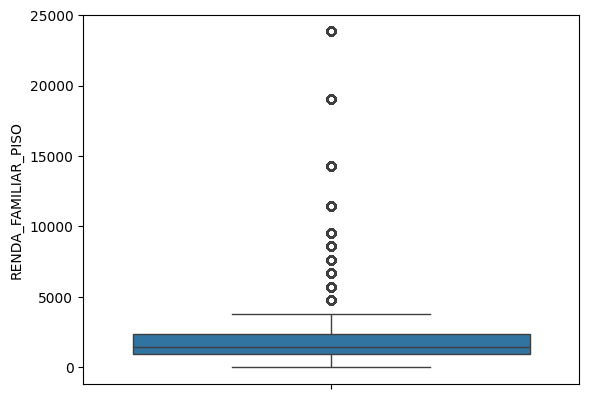

In [ ]:
sns.boxplot(amostra["RENDA_FAMILIAR_PISO"])

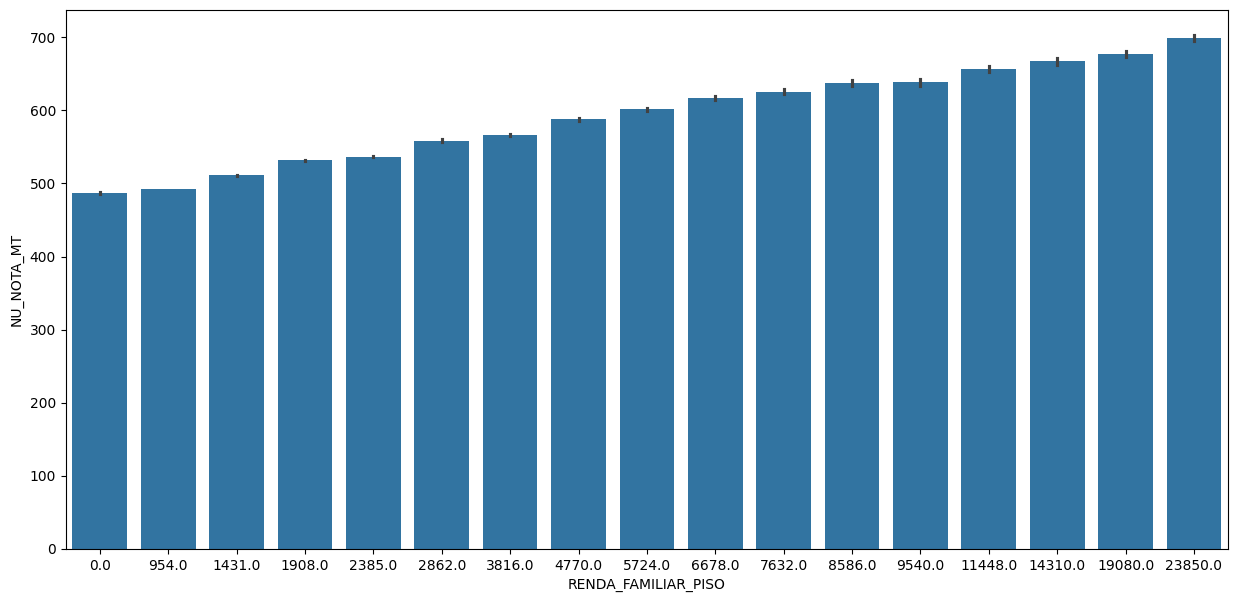

In [ ]:
plt.figure(figsize=(15, 7))
sns.barplot(data=amostra, x=amostra['RENDA_FAMILIAR_PISO'], y=amostra['NU_NOTA_MT'])
plt.show()

Observa-se de modo visual que as notas tendem a sofrer um aumento considerável conforme a renda do participante aumenta, verificaremos isso posteriormente na sessão de testes de hipótese.

2763133    477.04
4374389    539.96
4628081    687.94
2831223    484.74
2906099    475.60
            ...  
4064409    616.18
4277646    472.34
4125989    596.30
477705     421.80
4422864    536.24
Name: NOTA_MEDIA, Length: 343300, dtype: float64


<Axes: xlabel='TP_SEXO', ylabel='NOTA_MEDIA'>

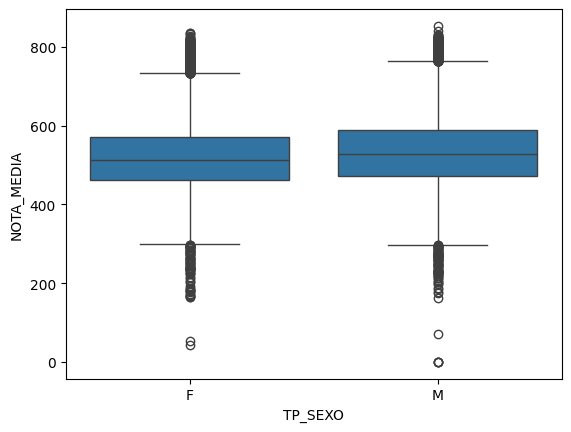

In [ ]:
amostra['NOTA_MEDIA'] = (amostra['NU_NOTA_CH'] + amostra['NU_NOTA_CN'] + amostra['NU_NOTA_LC'] + amostra['NU_NOTA_REDACAO'] + amostra['NU_NOTA_MT'])/5
visualizacao = amostra['NOTA_MEDIA'].dropna()
print(visualizacao)
sns.boxplot(y=visualizacao, x=amostra['TP_SEXO'])

Os boxplots parecem visualmente próximos, o que pode indicar pouco diferença entre os grupos analisados, posteriormente nesse trabalho, na sessão de testes de hipótese, verificaremos isso com rigor estatśtico.

### Matriz Correlação
Aqui observamos a matriz correlação para possíveis relações de fácil detecção entre nossas variaveis quantitativas


Matriz de Correlação (Valores):
                     RENDA_FAMILIAR_PISO  NOTA_MEDIA  NU_NOTA_CN  NU_NOTA_CH  \
RENDA_FAMILIAR_PISO             1.000000    0.437801    0.363722    0.373024   
NOTA_MEDIA                      0.437801    1.000000    0.713757    0.800775   
NU_NOTA_CN                      0.363722    0.713757    1.000000    0.583230   
NU_NOTA_CH                      0.373024    0.800775    0.583230    1.000000   
NU_NOTA_LC                      0.400735    0.823428    0.590049    0.728607   
NU_NOTA_MT                      0.373051    0.717995    0.485213    0.528068   
NU_NOTA_REDACAO                 0.317173    0.847759    0.475306    0.530528   

                     NU_NOTA_LC  NU_NOTA_MT  NU_NOTA_REDACAO  
RENDA_FAMILIAR_PISO    0.400735    0.373051         0.317173  
NOTA_MEDIA             0.823428    0.717995         0.847759  
NU_NOTA_CN             0.590049    0.485213         0.475306  
NU_NOTA_CH             0.728607    0.528068         0.530528  
NU_NOTA_LC 

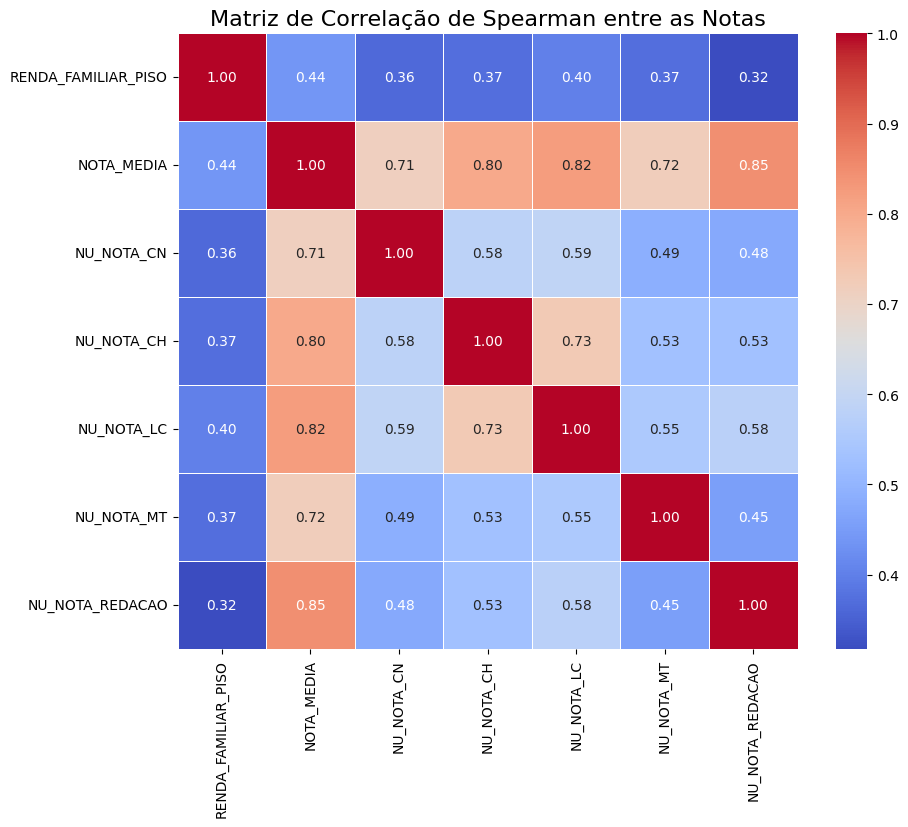

In [ ]:
df_correlacao = amostra[['RENDA_FAMILIAR_PISO', 'NOTA_MEDIA', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']].corr(method='spearman')
#nessa matriz corr utilizamos o método de spearman por não exigir que os dados estejam normalmente distribuidos (o que testaremos abaixo nessa análise)
print("\nMatriz de Correlação (Valores):")
print(df_correlacao)

plt.figure(figsize=(10, 8))

sns.heatmap(
    df_correlacao,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5
)

plt.title('Matriz de Correlação de Spearman entre as Notas', fontsize=16)

plt.show()

Pode-se observar relações claras entre as notas individuais e finais, principalmente a nota de redação, que é a mais relacionada com a nota média.
A renda e a nota média apresentam uma relação moderada.

### Visualização da distribuição dos dados
Distribuição dos dados visualmente

Text(0.5, 1.0, 'Histograma dos Dados de Nota')

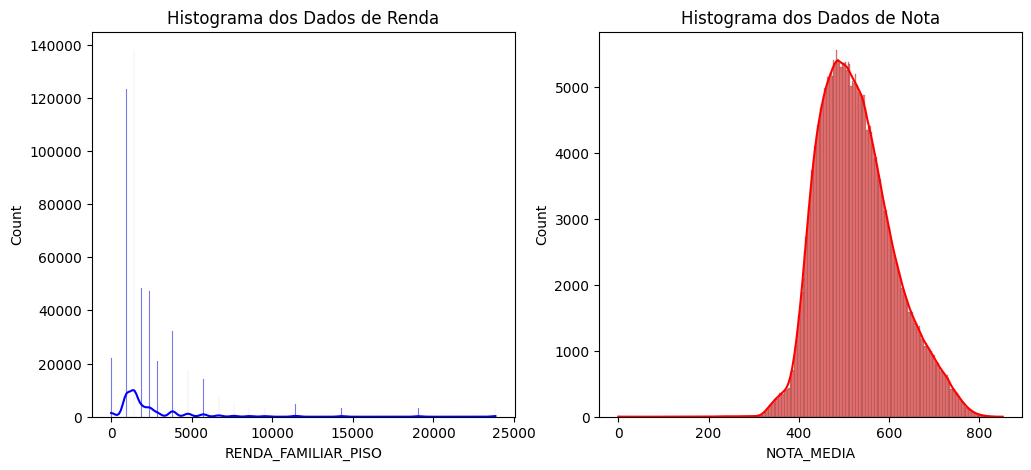

In [ ]:
plt.figure(figsize=[12, 5])

plt.subplot(1, 2, 1)
sns.histplot(amostra['RENDA_FAMILIAR_PISO'], kde=True, color='blue')
plt.title('Histograma dos Dados de Renda')

plt.subplot(1, 2, 2)
sns.histplot(amostra['NOTA_MEDIA'], kde=True, color='red')
plt.title('Histograma dos Dados de Nota')

Como é possível observar, os gráficos se assemelham de modo visual à uma distribuição normal.

### Teste da normalidade para os dados quantitativos do banco de dados
Aqui realizamos o teste para ver se de fato os dados estão distribuidos em uma Normal

In [ ]:
#realizando o Teste de Shapiro-Wilk
stat1, p1 = stats.shapiro(amostra['RENDA_FAMILIAR_PISO'])
notas_validas = amostra['NOTA_MEDIA'].dropna()
stat2, p2 = stats.shapiro(notas_validas)

print(f'Dados Renda: Estatística={stat1:.3f}, p-valor={p1:.3f}')
print(f'Dados Notas: Estatística={stat2:.3f}, p-valor={p2:.3f}')

alpha = 0.05

if p1 > alpha:
    print('\nPara as Rendas: A amostra parece ser normalmente distribuída (falhamos em rejeitar H0).')
else:
    print('\nPara as Rendas: A amostra não parece ser normalmente distribuída (rejeitamos H0).')

if p2 > alpha:
    print('Para as Notas: A amostra parece ser normalmente distribuída (falhamos em rejeitar H0).')
else:
    print('Para as Notas: A amostra não parece ser normalmente distribuída (rejeitamos H0).')

Dados Renda: Estatística=0.558, p-valor=0.000
Dados Notas: Estatística=0.981, p-valor=0.000

Para as Rendas: A amostra não parece ser normalmente distribuída (rejeitamos H0).
Para as Notas: A amostra não parece ser normalmente distribuída (rejeitamos H0).


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 498602.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 343300.
  res = hypotest_fun_out(*samples, **kwds)


Rejeitamos H0 em ambos os casos, o que significa que os dados não seguem a distribuição normal, portanto, os testes de hipótese a partir desse momento usarão métodos não paramétricos

# Testes de Hipótese


## Renda X Nota Redação

Utilizaremos o Teste de Mann-Whitney U (alternativa não paramétrica ao Teste t de Student) com significância de 5%

H0: A distribuição das notas de redação é a mesma para os grupos de 'Baixa Renda' e 'Alta Renda'

H1: A distribuição das notas de redação não é a mesma entre os dois grupos

População Baixa Renda: 2009408 participantes
População Alta Renda: 1649724 participantes
------------------------------
Estatística do teste: 1144160869638.000
P-valor: 0.0

Conclusão: Rejeitamos H0. Há uma diferença estatisticamente significativa.


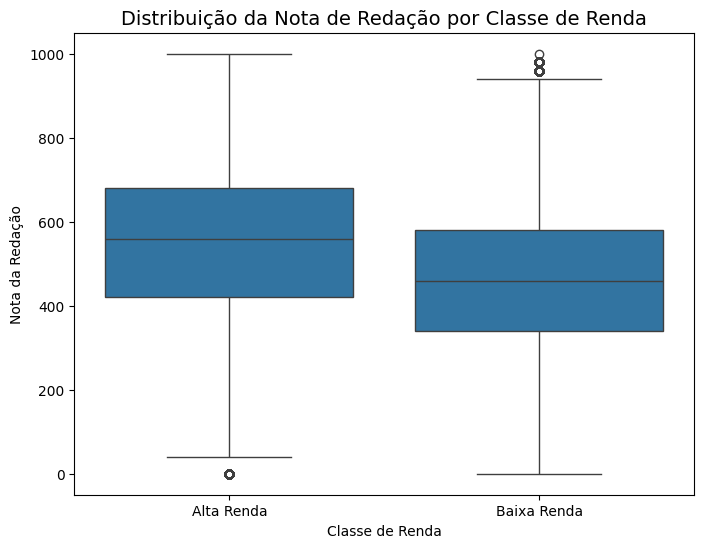

In [ ]:
# 1. SEPARAÇÃO DOS GRUPOS
notas_baixa_renda = df2[df2['CLASSE_RENDA'] == 'Baixa Renda']['NU_NOTA_REDACAO'].dropna()
notas_alta_renda = df2[df2['CLASSE_RENDA'] == 'Alta Renda']['NU_NOTA_REDACAO'].dropna()

print(f"População Baixa Renda: {notas_baixa_renda.shape[0]} participantes")
print(f"População Alta Renda: {notas_alta_renda.shape[0]} participantes")
print("-" * 30)

# 2. TESTE DE MANN-WHITNEY U
stat, p_valor = mannwhitneyu(notas_baixa_renda, notas_alta_renda)
alpha = 0.05

print(f"Estatística do teste: {stat:.3f}")
print(f"P-valor: {p_valor}")

if p_valor <= alpha:
  print("\nConclusão: Rejeitamos H0. Há uma diferença estatisticamente significativa.")
else:
  print("\nConclusão: Falhamos em rejeitar H0.")

# 3. VISUALIZAÇÃO
plt.figure(figsize=(8, 6))
sns.boxplot(x='CLASSE_RENDA', y='NU_NOTA_REDACAO', data=df2.dropna(subset=['NU_NOTA_REDACAO']))
plt.title('Distribuição da Nota de Redação por Classe de Renda', fontsize=14)
plt.ylabel('Nota da Redação')
plt.xlabel('Classe de Renda')
plt.show()

#### Análise Visual do Gráfico (Renda vs. Redação)

O boxplot acima ilustra a distribuição das notas de redação para os grupos de "Baixa Renda" e "Alta Renda". Visualmente, notamos que:
- A **mediana** (a linha central do retângulo) do grupo de "Alta Renda" é visivelmente superior à do grupo de "Baixa Renda".
- A **amplitude interquartil** (o tamanho da caixa, representando 50% dos dados centrais) do grupo de "Alta Renda" também se posiciona em uma faixa de notas mais elevada.
- Embora haja sobreposição, a distribuição geral do grupo de "Alta Renda" está deslocada para notas maiores.

Esta análise visual sugere que existe uma diferença prática entre os grupos, o que reforça o resultado do teste de hipótese.

## Raça X Nota Média

Utilizaremos o Teste de Kruskal-Wallis, uma vez que, estamos comparando mais de dois grupos independentes e os dados não são normais

H0: A distribuição das notas médias é a mesma para todos os grupos de raça/cor

H1: Pelo menos um dos grupos possui uma distribuição de notas médias diferente dos demais

População por grupo de Raça/Cor:
- Não declarado: 71929 participantes
- Branca: 1286483 participantes
- Preta: 478919 participantes
- Parda: 1725423 participantes
- Amarela: 82167 participantes
- Indígena: 22495 participantes
------------------------------
Estatística do teste: 159441.300
P-valor: 0.0

Conclusão: Rejeitamos H0. Existe uma diferença estatisticamente significativa.


/tmp/ipython-input-45-1619174147.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['RACA_NOME'] = df2['TP_COR_RACA'].map(mapa_raca)


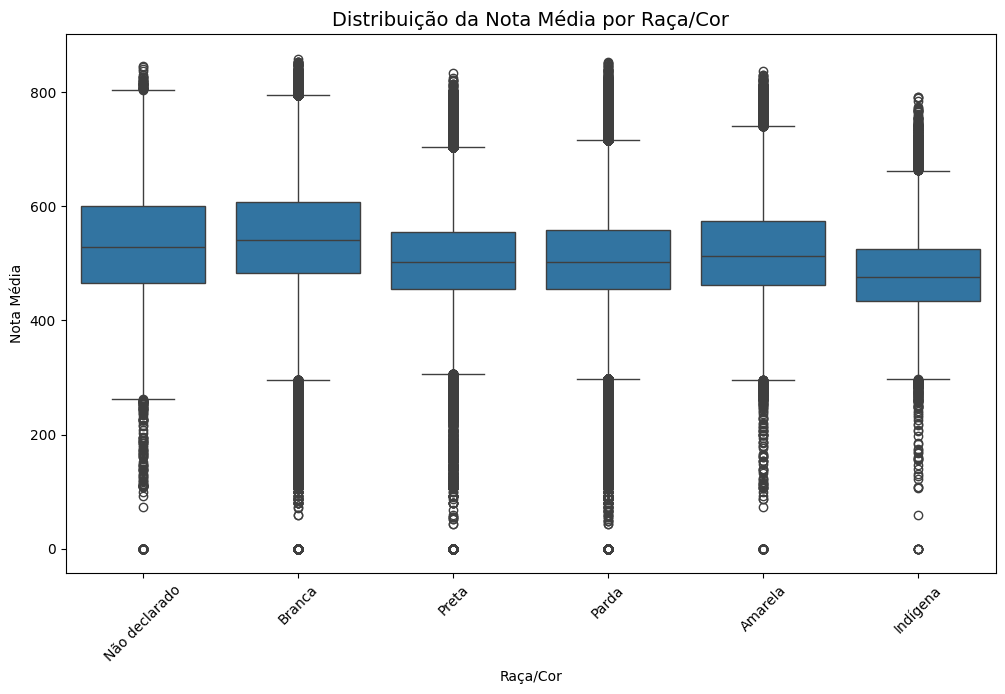

In [ ]:
# 1. SEPARAÇÃO DOS GRUPOS
mapa_raca = { 0: 'Não declarado', 1: 'Branca', 2: 'Preta', 3: 'Parda', 4: 'Amarela', 5: 'Indígena' }
grupos_raca = []
labels_raca = []
for raca_code, raca_nome in mapa_raca.items():
    notas_grupo = df2[df2['TP_COR_RACA'] == raca_code]['NOTA_MEDIA'].dropna()
    if not notas_grupo.empty:
        grupos_raca.append(notas_grupo)
        labels_raca.append(raca_nome)

print("População por grupo de Raça/Cor:")
for i in range(len(labels_raca)):
    print(f"- {labels_raca[i]}: {len(grupos_raca[i])} participantes")
print("-" * 30)

# 2. TESTE DE KRUSKAL-WALLIS
stat, p_valor = kruskal(*grupos_raca)
alpha = 0.05

print(f"Estatística do teste: {stat:.3f}")
print(f"P-valor: {p_valor}")

if p_valor <= alpha:
  print("\nConclusão: Rejeitamos H0. Existe uma diferença estatisticamente significativa.")
else:
  print("\nConclusão: Falhamos em rejeitar H0.")

# 3. VISUALIZAÇÃO
df2['RACA_NOME'] = df2['TP_COR_RACA'].map(mapa_raca)
plt.figure(figsize=(12, 7))
sns.boxplot(x='RACA_NOME', y='NOTA_MEDIA', data=df2.dropna(subset=['NOTA_MEDIA']), order=labels_raca)
plt.title('Distribuição da Nota Média por Raça/Cor', fontsize=14)
plt.ylabel('Nota Média')
plt.xlabel('Raça/Cor')
plt.xticks(rotation=45)
plt.show()

#### Análise Visual do Gráfico (Raça/Cor vs. Média)

A análise visual dos boxplots para os diferentes grupos de raça/cor revela diferenças nas distribuições das notas médias (ainda que não tão significativas quanto a distribuição das notas de redação para os grupos de "Baixa Renda" e "Alta Renda")

A distância visual entre as medianas, especialmente entre os grupos de maior e menor desempenho, sugere que as diferenças não são apenas estatísticas, mas também práticas e relevantes.

## Sexo X Nota Média
Utilizaremos o Teste de Mann-Whitney U (alternativa não paramétrica ao Teste t de Student) com significância de 5% e uma fração de ~10% da população para a análise

H0: Não há diferença significativa na distribuição dos dados entre a amostra masculina e feminina

H1: Há uma diferença significativa na distribuição dos dados entre a amostra masculina e feminina

População Masculina: 1423388 participantes
População Feminina: 2011370 participantes
------------------------------
Estatística do teste: 1566111124444.500
P-valor: 0.0

Conclusão: Rejeitamos H0. Há uma diferença estatisticamente significativa.


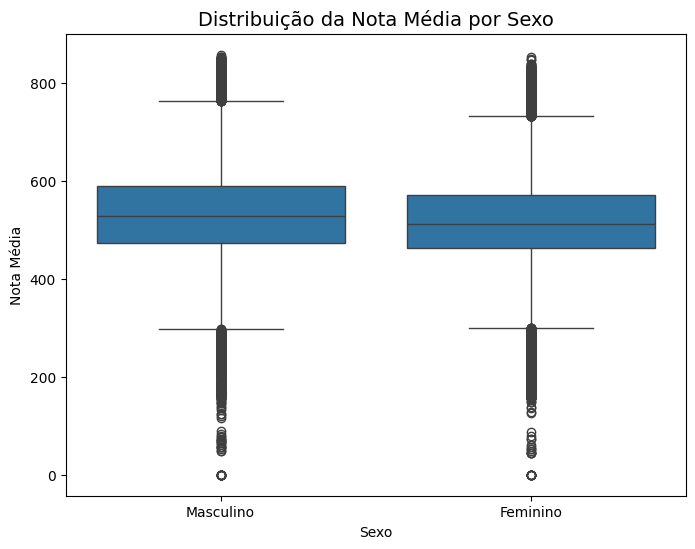

In [ ]:
# 1. PREPARAÇÃO E SEPARAÇÃO DOS GRUPOS
# Usando o dataframe original 'df' e removendo nulos para garantir que todos têm notas
grupo_masculino = df2[df2["TP_SEXO"] == 'M'].dropna(subset=['NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_LC', 'NU_NOTA_REDACAO', 'NU_NOTA_MT'])
grupo_feminino = df2[df2["TP_SEXO"] == 'F'].dropna(subset=['NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_LC', 'NU_NOTA_REDACAO', 'NU_NOTA_MT'])

print(f"População Masculina: {grupo_masculino.shape[0]} participantes")
print(f"População Feminina: {grupo_feminino.shape[0]} participantes")
print("-" * 30)

# 2. TESTE DE MANN-WHITNEY U
notas_m = grupo_masculino['NOTA_MEDIA']
notas_f = grupo_feminino['NOTA_MEDIA']
stat, p_valor = mannwhitneyu(notas_m, notas_f)
alpha = 0.05

print(f"Estatística do teste: {stat:.3f}")
print(f"P-valor: {p_valor}")

if p_valor <= alpha:
  print("\nConclusão: Rejeitamos H0. Há uma diferença estatisticamente significativa.")
else:
  print("\nConclusão: Falhamos em rejeitar H0.")

# 3. VISUALIZAÇÃO
# Junta os dois dataframes para o gráfico
df_sexo_completo = pd.concat([grupo_masculino, grupo_feminino])
plt.figure(figsize=(8, 6))
sns.boxplot(x='TP_SEXO', y='NOTA_MEDIA', data=df_sexo_completo)
plt.title('Distribuição da Nota Média por Sexo', fontsize=14)
plt.xlabel('Sexo')
plt.ylabel('Nota Média')
plt.xticks([0, 1], ['Masculino', 'Feminino'])
plt.show()

#### Análise Visual do Gráfico (Sexo vs. Média)

Ao analisar o boxplot que compara as notas médias entre os sexos, observamos um ponto interessante:
- As **medianas** de ambos os grupos ("Masculino" e "Feminino") são **visualmente muito próximas**, quase idênticas.
- A **amplitude dos dados** e os quartis também mostram uma sobreposição muito grande entre as duas distribuições.

Essa análise visual é um contraponto importante ao teste de hipótese. Enquanto o teste estatístico, devido ao grande volume de dados, detectou uma diferença (rejeitou H₀), o gráfico mostra que essa diferença é **muito pequena na prática**.

## Discussão e Conclusão Geral

Este estudo se propôs a investigar a relação entre fatores socioeconômicos/demográficos e o desempenho no ENEM 2018. Utilizando o conjunto de dados completo de não-treineiros, os testes de hipótese não paramétricos (Mann-Whitney U e Kruskal-Wallis) rejeitaram a hipótese nula em todas as análises, indicando a existência de diferenças **estatisticamente significativas** entre os grupos de renda, raça/cor e sexo.

## Significância Estatística vs. Prática

Um ponto fundamental, levantado durante a análise, é a distinção entre significância estatística e significância prática, especialmente em datasets com milhões de registros como o do ENEM. Com tanto poder estatístico, os testes são capazes de detectar diferenças mínimas, que podem não ser relevantes na prática.

# Conclusão Final

O objetivo inicial do estudo foi plenamente alcançado. Foi possível confirmar, com rigor estatístico, que fatores como renda e raça/cor estão fortemente associados ao desempenho dos estudantes no ENEM, evidenciando desigualdades estruturais. Além disso, a análise proporcionou uma importante lição sobre a interpretação de resultados em grandes volumes de dados, demonstrando que uma análise crítica e visual é essencial para contextualizar os achados dos testes de hipótese e entender a relevância prática das diferenças encontradas.